In [165]:
import pandas as pd
import numpy as np

def turn_to_hr(target):
    time = target.hour + target.minute/60
    return (time)

def turn_to_hr_str(target):
    time = int(target.split(":")[0]) + int(target.split(":")[1])/60
    return time

In [166]:
'''
ref_table = pd.read_csv("Hubs Compare Table.csv")
ref_table.dropna(how = "all", axis = 1, inplace = True)
ref_table.columns = ["GS_Country", "GS_Hub","M_Country", "M_Hub" ]
ref_table = ref_table.drop(0, axis = 0)
'''

'\nref_table = pd.read_csv("Hubs Compare Table.csv")\nref_table.dropna(how = "all", axis = 1, inplace = True)\nref_table.columns = ["GS_Country", "GS_Hub","M_Country", "M_Hub" ]\nref_table = ref_table.drop(0, axis = 0)\n'

In [219]:
ref_table = pd.read_csv("../Database/Hub list.csv")
ref_table["Ref_City"] = ref_table.Ref_City + "-"+ ref_table.Country



In [220]:
# Read files 

#distances = pd.read_excel("Simple Routes.xlsx", sheet_name = 0)
distances = pd.read_excel("../Database/Simple/Simple Routes.xlsx")
#distances.columns = ["", 'Origin Country', 'Destination Country', 'From', 'To', 'Distance', 'Time Format', 'Time', 'Duration']
schedule = pd.read_csv("raw data/tn_rs.csv") # Read the current network (Used/Nonused)
schedule.replace("Ryton Gateway", "Ryton", inplace = True)


In [221]:
print(f"there are {len(distances)} rows in the distacnes file")

there are 5476 rows in the distacnes file


In [222]:
# Gather the list of cities

hub_list_in_GS =  ref_table["City"].tolist()
org_list = schedule["Org. GTW"].unique().tolist()

hub_ref = {}
count = 0
for x in org_list:
    for y in hub_list_in_GS:
        if x in y:
            msname = ref_table[ref_table["City"] == y]["Ref_City"]
            hub_ref[x] =  msname.values[0]
            break
    
    else:
        print(f"{x} is not in the list")
        count = count+1
 
print(count / len(org_list))
        
count = 0
des_list = schedule["Dst. GTW"].unique().tolist()
for x in des_list:
    for y in hub_list_in_GS:
        if x in y:
            msname = ref_table[ref_table["City"] == y]["Ref_City"]
            hub_ref[x] =  msname.values[0]
            break
    
    else:
        print(f"{x} is not in the list")
        count = count+1
        
print(count)

0.0
0


In [223]:
schedule["agg"] = schedule["Org. GTW"] + schedule["Dst. GTW"]

In [224]:
for x in schedule.index:
    a = schedule.loc[x, "Distance in km"]
    if type(a) == str:
        schedule.loc[x, "Distance in km"] = 0

In [225]:
schedule["Speed"] = schedule["Distance in km"] / schedule["Travel time"]
schedule = schedule[schedule.Speed <= 100] # Get rid of those columns with impossible values

In [226]:
# In the current schedule, 1 route usually has several rows because of the different schedule arrangement.
# Only choose the row that is the most reasonable.
list_for_df = []
for agg in schedule["agg"].unique():
    agg_info = schedule[schedule["agg"] == agg]
    pick = agg_info[agg_info["Speed"] == agg_info["Speed"].max()]
    #list_for_df.append([agg_info["Org. GTW"].unique()[0], agg_info["Dst. GTW"].unique()[0], agg_info["Travel time"].median() , agg_info["Distance in km"].median()])
    list_for_df.append([pick["Org. GTW"].tolist()[0], pick["Dst. GTW"].tolist()[0], pick["Travel time"].tolist()[0] , pick["Distance in km"].tolist()[0]])

In [227]:
agg_info["Speed"].max()

64.16666666666667

In [228]:
# To delete the duplicated routes, we create a new dataset called "compare"

compare = pd.DataFrame(list_for_df, columns = ["Org. GTW", "Dst. GTW", "Travel time", "Distance in km"])
compare["bing distance"] = ""
compare["bing driving time"] = ""

In [229]:
compare

,Org. GTW,Dst. GTW,Travel time,Distance in km,bing distance,bing driving time
0,Ostrava,Zabrze,2.000000,82,,
1,Plzen,Feucht,3.000000,190,,
2,Speyer,Barcelona,16.000000,1233,,
3,Speyer,Madrid,24.000000,1816,,
4,Speyer,Vitoria,55.500000,1452,,
...,...,...,...,...,...,...
72,Zlin,Strečno,1.500000,130,,
73,Ivanka pri Dunaji,Ricany - Jazlovice,5.516667,330,,
74,Brno,OLK,8.000000,320,,
75,NPKK,Regensburg,9.000000,700,,


In [230]:
dist_col_name = "Distance"
time_col_name = "Duration"


def find_dist(org, dst):
    if org in hub_ref.keys():
        org = hub_ref[org]
    else:
        print(f"in the route of {org} and {dst}, {org} can't find")
    if dst in hub_ref.keys():
        dst = hub_ref[dst]
    else:
        print(f"in the route of {org} and {dst}, {dst} can't find")
        
    km = distances.loc[(distances["From"] == org) & (distances["To"] == dst), dist_col_name]
    time = distances.loc[(distances["From"] == org) & (distances["To"] == dst), time_col_name]
    return [km, time]

In [231]:
distances

,Origin Country,Destination Country,From,To,Distance,Duration
0,AT,AT,Hub Graz-AT,Hub Graz-AT,0.000,0.000000
1,AT,AT,Hub Graz-AT,Hub Wien I-AT,198.409,1.883333
2,AT,BE,Hub Graz-AT,Brüssel-BE,1122.724,9.450000
3,AT,BG,Hub Graz-AT,Sofia-BG,951.814,9.333333
4,AT,CZ,Hub Graz-AT,Brno-CZ,341.843,3.450000
...,...,...,...,...,...,...
5471,CZ,AT,Zlin-CZ,Wals-AT,422.419,4.033333
5472,CZ,AT,Zlin-CZ,Wundschuh-AT,421.029,4.066667
5473,CZ,AT,Zlin-CZ,Wernberg-AT,567.374,5.400000
5474,CZ,DE,Zlin-CZ,PZ 44 (Bochum) [im Bau]-DE,968.880,8.283333


In [232]:
for row in compare.index:
    org = compare.loc[row, "Org. GTW"]
    dst = compare.loc[row, "Dst. GTW"]
    ans = find_dist(org, dst)

    if len(ans[0]) != 0:
        compare.loc[row, "bing distance"] = ans[0].values[0]
        compare.loc[row, "bing driving time"] = ans[1].values[0]

In [233]:
distances.loc[(distances["From"] == hub_ref["Regensburg"]) & (distances["To"] == hub_ref["Wien 1"]), :]

,Origin Country,Destination Country,From,To,Distance,Duration
1037,DE,AT,PZ 93 (Regensburg)-DE,Hub Wien I-AT,396.523,3.45


In [234]:
compare_found = compare[compare["bing distance"] != ""].sort_values("Distance in km")
print(f"{len(compare_found)} out of {len(schedule)} are covered")

76 out of 172 are covered


In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

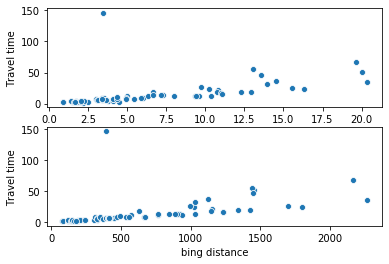

In [236]:
fix = plt.subplot(2,1,1)
sns.scatterplot(x = "bing driving time", y = "Travel time", data = compare_found)

fix = plt.subplot(2,1,2)
sns.scatterplot(x = "bing distance", y = "Travel time", data = compare_found)

#%matplotlib inline

# Using simple equations to model the travel time using the driving time.
Minimize the MSE

In [237]:
compare.dropna(how = "any", inplace = True)

def tt_est(daily_max, rest, offset, dt_offset, driving_time):
    # daily_max # assume 12 at this moment
    # rest # assume the bus driver have to rest at least 8 hours between 2 days
    # offset # assume the bus need to drive out and in to the hub, and it takes time
    # dt_offset # adjust the speed.
    driving_time = driving_time*dt_offset
    hour = driving_time % daily_max
    ext_hour = driving_time //daily_max* (rest+daily_max)  # Calculate the time it need for every extended day
    
    return hour + ext_hour + offset # 1 means the buffer time

def cal_mse(df):
    return sum((df["est_tt"] - df["Travel time"])**2)



In [238]:
compare = compare[compare["bing driving time"] != ""]

In [239]:
compare

,Org. GTW,Dst. GTW,Travel time,Distance in km,bing distance,bing driving time
0,Ostrava,Zabrze,2.000000,82,80.536,0.883333
1,Plzen,Feucht,3.000000,190,189.205,1.71667
2,Speyer,Barcelona,16.000000,1233,1230.86,11.0667
3,Speyer,Madrid,24.000000,1816,1797.45,16.3167
4,Speyer,Vitoria,55.500000,1452,1436.76,13.05
...,...,...,...,...,...,...
72,Zlin,Strečno,1.500000,130,140.749,2.2
73,Ivanka pri Dunaji,Ricany - Jazlovice,5.516667,330,331.7,3.13333
74,Brno,OLK,8.000000,320,317.376,3.03333
75,NPKK,Regensburg,9.000000,700,671.789,5.9


22439.872259722226


/Users/yi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


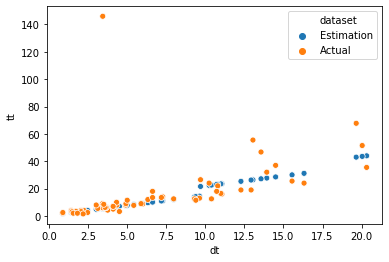

In [240]:

compare["est_tt"] = compare.apply(lambda row: tt_est(14,7,0.5,1.45,row["bing driving time"]), axis = 1)
print(cal_mse(compare))

# Visualize
set1 = compare.loc[:, ["bing driving time", "est_tt"]]
set1.columns = ["dt", "tt"] 
set2 = compare.loc[:, ["bing driving time", "Travel time"]]
set2.columns = ["dt", "tt"]
plot_dataset = pd.concat([set1.assign(dataset='Estimation'), set2.assign(dataset='Actual')])
plot_dataset
sns.scatterplot(data = plot_dataset , x = "dt", y = "tt", hue = "dataset")

In [241]:
dm = [x for x in range(10, 15)]
rest = [x for x in range(8, 12)]
offset = [x/2 for x in range(0, 4)]
dt_offset = [x/10 for x in range(10, 15)]
grid_search = [(a, b, c, d) for a in dm for b in rest for c in offset for d in dt_offset]
gs_result = []
for a, b, c, d in grid_search: 
    compare["est_tt"] = compare.apply(lambda row: tt_est(a,b,c,d,row["bing driving time"]), axis = 1)
    gs_result.append([a, b, d, d, cal_mse(compare)])

/Users/yi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [242]:
gs_result = pd.DataFrame(gs_result)
best_set = gs_result.loc[gs_result[4] == gs_result[4].min(), 0:3].values.tolist()[0]

In [243]:
# using the best set to train the rest of the data
a, b, c, d = best_set
compare["est_tt"] = compare.apply(lambda row: tt_est(a,b,c,d,row["bing driving time"]), axis = 1)

/Users/yi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


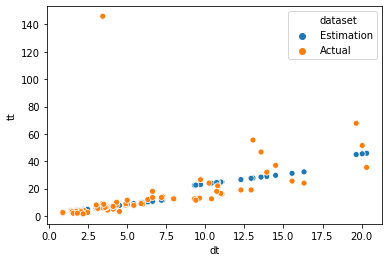

In [244]:
# Visualize
set1 = compare.loc[:, ["bing driving time", "est_tt"]]
set1.columns = ["dt", "tt"] 
set2 = compare.loc[:, ["bing driving time", "Travel time"]]
set2.columns = ["dt", "tt"]
plot_dataset = pd.concat([set1.assign(dataset='Estimation'), set2.assign(dataset='Actual')])
plot_dataset
sns.scatterplot(data = plot_dataset , x = "dt", y = "tt", hue = "dataset")

In [245]:
# Calculate the estimated travel time
distances["est_tt"] = 0
distances["est_tt"] = distances.apply(lambda row: tt_est(a,b,c,d,row["Duration"]), axis = 1)

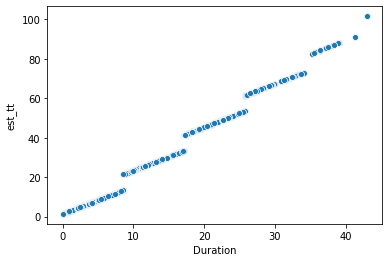

In [246]:
sns.scatterplot(data = distances, x = "Duration", y = "est_tt")

In [247]:
distances.to_csv("../Database/travel time.csv")

In [249]:
distances.From.unique()

array(['Hub Graz-AT', 'Hub Wien I-AT', 'Brüssel-BE', 'Sofia-BG',
       'Brno-CZ', 'Ostrava-CZ', 'Krupka 1-CZ', 'Plzen 1-CZ',
       'Hradec Kralove - Brezhrad-CZ', 'PZ 67 (Speyer)-DE',
       'PZ 50 (Köln)-DE', 'PZ 04 (Radefeld/Leipzig)-DE',
       'PZ 90 (Feucht/Nürnberg)-DE', 'PZ 77 (Lahr)-DE',
       'PZ 93 (Regensburg)-DE', 'PZ 21 (Hamburg)-DE',
       'PZ 46 (Dorsten)-DE', 'PZ 58 (Hagen)-DE', 'PZ 08 (Neumark)-DE',
       'PZ 47 (Krefeld)-DE', 'PZ 15 (Rüdersdorf)-DE', 'Kolding-DK',
       'Barcelona-ES', 'Madrid-ES', 'Araba (Vitoria)-ES',
       'Lieto (Turku)-FL', 'Vantaa (Helsinki)-FL', 'Combs la ville-FR',
       'Slough-GB', 'Ryton Gateway-GB', 'Spata-GR', 'Zagreb-HR',
       'Budapest OLK-HU', 'Budapest NPKK (OE)-HU', 'Portlaoise-IE',
       'Kaunas-LT', 'Bettembourg-LU', 'Eindhoven-Noord-NL',
       'Utrecht-West + Centrum-NL', 'Zaltbommel-NL', 'Oslo-NO',
       'Suwałki (Ełk)-PL', 'Poznań-PL', 'Zabrze-PL', 'Koninko-PL',
       'Wrocław-PL', 'Bydgoszcz (Solec Kujawski)-PL', 